This notebook demonstrates the scripts which illustrate the theoretical part of the project. It includes:
* Given a polynomial, constructing an incomplete matrix whose factorizations are strongly equivalent to the roots of the polynomial in [0,1] interval
* Applying variable gadget & removing variables
* Given a matrix factorization which corresponds to particular polynomial, construct the root of the polynomial based on factorization 

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import matplotlib.widgets as widgets
from matplotlib.image import AxesImage
from matplotlib.gridspec import GridSpec
import numpy as np
from itertools import product

from theory.transform import matrix_from_formula, remove_variables
from theory.fact_of_transform import create_factorization_var_gadgets
from theory.poly_solution_from_fact import solution_from_factorization

from theory.represent import from_rank_1_list_to_WH

from nmf.norms import norm_Frobenius
from itertools import zip_longest

import json
from itertools import product

In [3]:
# plot matrix with labels

def show_matrix_with_vars(matrix_numbers, matrix_variables, ax, title=None, print_variables=False, print_numbers=False):
    ax.set_axis_off()
    matrix_numbers = np.copy(matrix_numbers)
    # entries of matrix_numbers where variables are placed have value -1, it is convinient but it also distorts the color scheme
    matrix_numbers[matrix_numbers < 0] = 0
    
    ax.imshow(matrix_numbers, cmap="gray")
    ax.set_title(title)
    
    mid_value = np.max(matrix_numbers) / 2
    
    for i, j in product(range(matrix_variables.shape[0]), range(matrix_variables.shape[1])):
        if print_variables and matrix_variables[i, j] != "":
            ax.text(j, i, matrix_variables[i, j],
                 color="white",
                 backgroundcolor="black",
                 horizontalalignment="center")
        elif print_numbers:
            color="white" if matrix_numbers[i, j] < mid_value else "black"
            ax.text(j, i, "{:.2f}".format(matrix_numbers[i, j]), 
                       horizontalalignment="center",
                       color=color)

In [4]:
# interactive factorization plot

class InteractiveTermsPlot:
    def __init__(self, terms, V, figsize=None):
        gs = GridSpec(2, 3, width_ratios=[1, 10, 1], height_ratios=[10, 1])

        self.fact_fig = plt.figure(figsize=figsize)
        self.fact_ax = plt.subplot(gs[0, :])
        self.btn_less_ax = plt.subplot(gs[1, 0])
        self.slider_ax = plt.subplot(gs[1, 1])
        self.btn_more_ax = plt.subplot(gs[1, 2])
        self.fact_fig.suptitle("Rank 1 factorization terms")

        self.V = V
        self.terms = np.copy(terms)
        self.term_plot_range = [0, max(np.max(t) for t in self.terms)]

        self.slider = widgets.Slider(self.slider_ax,
                                     label="",
                                     valmin=0,
                                     valmax=len(self.terms) - 1,
                                     valfmt='%0.0f',
                                     valstep=1)
        self.slider.on_changed(self.on_slider_move)

        self.btn_less = widgets.Button(self.btn_less_ax, "<<")
        self.btn_less.on_clicked(lambda e: self.set_slider_val(self.slider.val - 1))

        self.btn_more = widgets.Button(self.btn_more_ax, ">>")
        self.btn_more.on_clicked(lambda e: self.set_slider_val(self.slider.val + 1))

        self.selected_sorting_points = []

        self.on_slider_move(0)

        self.fact_ax.set_axis_off()
            
    def set_slider_val(self, val):
        val = np.clip(val, self.slider.valmin, self.slider.valmax)
        self.slider.set_val(val)

    def on_slider_move(self, val):
        self.plot_ith_term(int(val))

    def plot_ith_term(self, i):
        for artist in self.fact_ax.get_children():
            if isinstance(artist, AxesImage): artist.remove()

        self.fact_ax.imshow(self.terms[i], zorder=0, vmin=self.term_plot_range[0], vmax=self.term_plot_range[1], cmap="gray")
        self.fact_fig.canvas.draw()


    @staticmethod
    def sort_matrices_by_element(l, position, reverse=False):
        c, r = position
        return sorted(l, key=lambda A: A[r, c], reverse=reverse)

In [5]:
def demonstrate_transformations(formula, solution):
    plt.close("all")
    
    # generate corresponding icnomplete matrix
    incomplete_mat_numbers, incomplete_mat_variables, expected_rank_with_variables, construction_data = matrix_from_formula(formula) 
    # note that construction_data variable does not contain solution but only names and indexing of the variables in the matrix
    
    f, ax = plt.subplots(figsize=(12, 13))
    show_matrix_with_vars(incomplete_mat_numbers, incomplete_mat_variables, ax, print_numbers=True, print_variables=True,
                          title="Incomplete matrix, shape {}, which factorization of size {}\nis strongly equivalen to the set of roots of \"{}\", roots restricted to a unit cube".format(
                              incomplete_mat_numbers.shape, expected_rank_with_variables, formula))
    
    # generate variable-free matrix
    matrix_numbers, matrix_variables, expected_rank_wo_variables, indexing_wrt_vars = remove_variables(incomplete_mat_numbers, incomplete_mat_variables, 
                                                                                                         construction_data["ranges"], expected_rank_with_variables)
    f, ax = plt.subplots(figsize=(12, 13))
    show_matrix_with_vars(matrix_numbers, matrix_variables, ax, print_variables=False, print_numbers=False,
                    title="(Variable-free) matrix, shape {}, which factorization of size {}\nis strongly equivalen to the set of roots of \"{}\", restricted to a unit cube".format(
                    matrix_numbers.shape, expected_rank_wo_variables, formula))

    # generate a factorization corresponding to the provided solution 
    terms = create_factorization_var_gadgets(matrix_numbers, indexing_wrt_vars, solution, construction_data)
    terms = np.array(terms)
    
    iplot = InteractiveTermsPlot(terms, matrix_numbers, figsize=(12, 13))
    print("Factorization accuracy:") 
    print("Frobenius norm of the difference between the sum of the factorization terms and a variable free matrix = {}(should be 0)".format(
        norm_Frobenius(np.sum(terms, axis=0) - matrix_numbers)))
    
    # generate solution based on the factorization (we generate factorization, then use it to demonstrate how a solution can be obtained from it)
    recovered_solution = solution_from_factorization(terms, construction_data) # 
    # note that construction_data variable does not contain solution but only names and indexing of the variables in the matrix
    
    print()
    print("provided solution:", solution)
    print("solution, obtained from factorization:", recovered_solution)
    print()
    
    # we must hold a reference to interactive plot
    print("Following about about the matrix construction was recorder and used:")
    print(json.dumps(construction_data, indent="\t", default=lambda x: str(x)))
    
    return iplot

2*x - 1


<IPython.core.display.Javascript object>


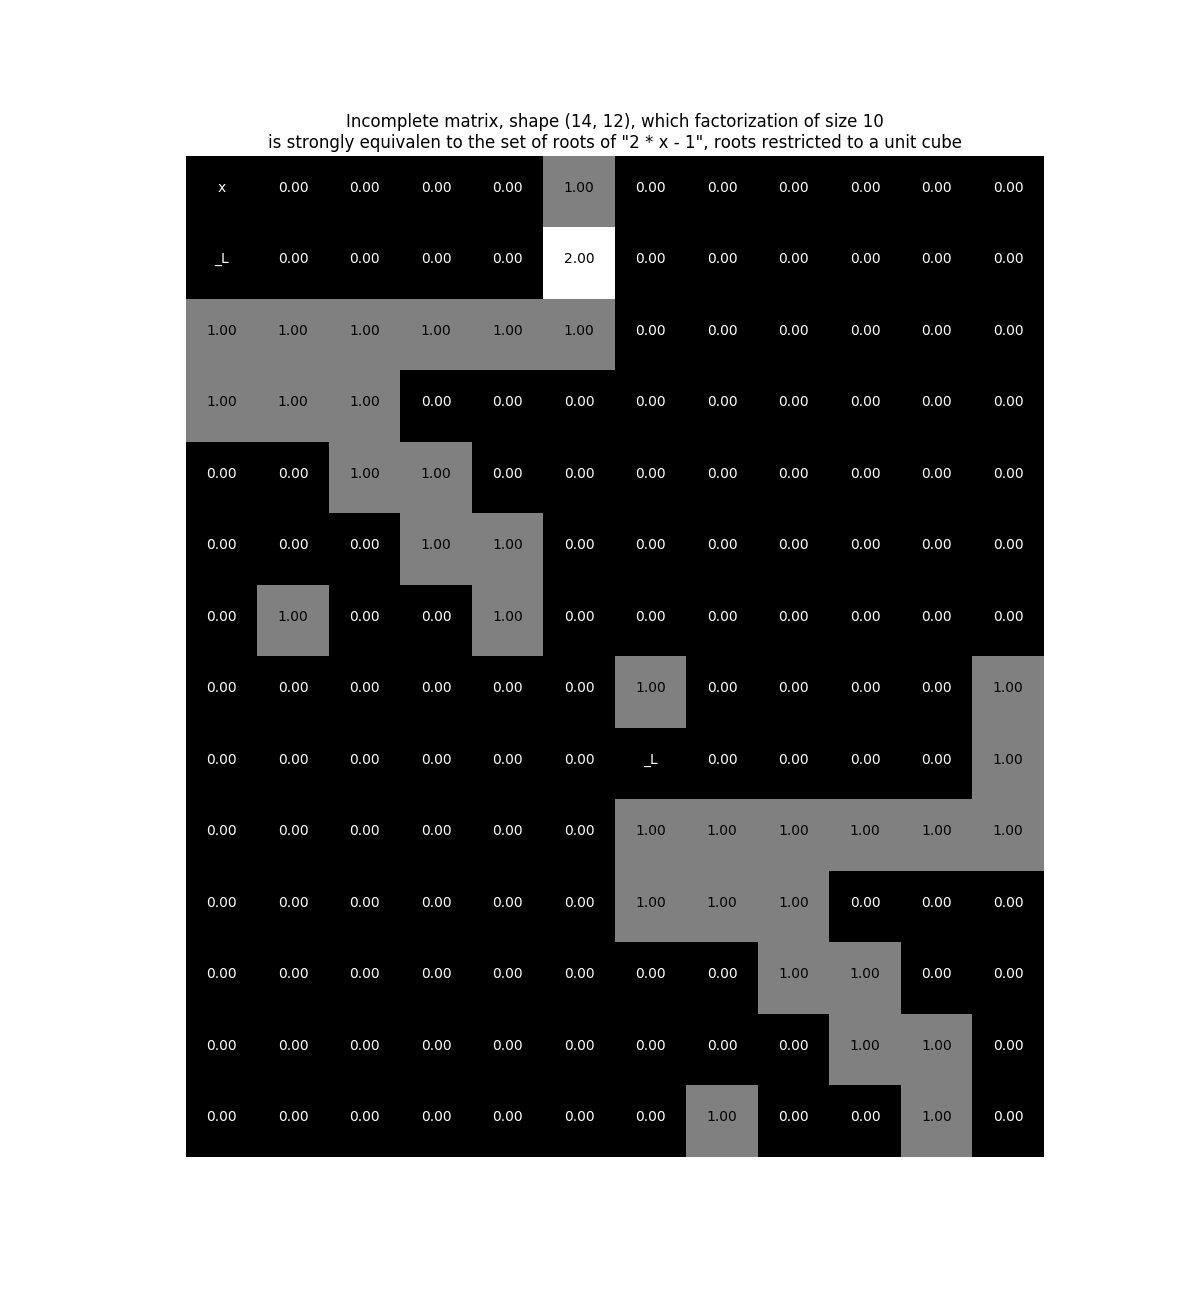

remove_variable _L
remove_variable x


<IPython.core.display.Javascript object>


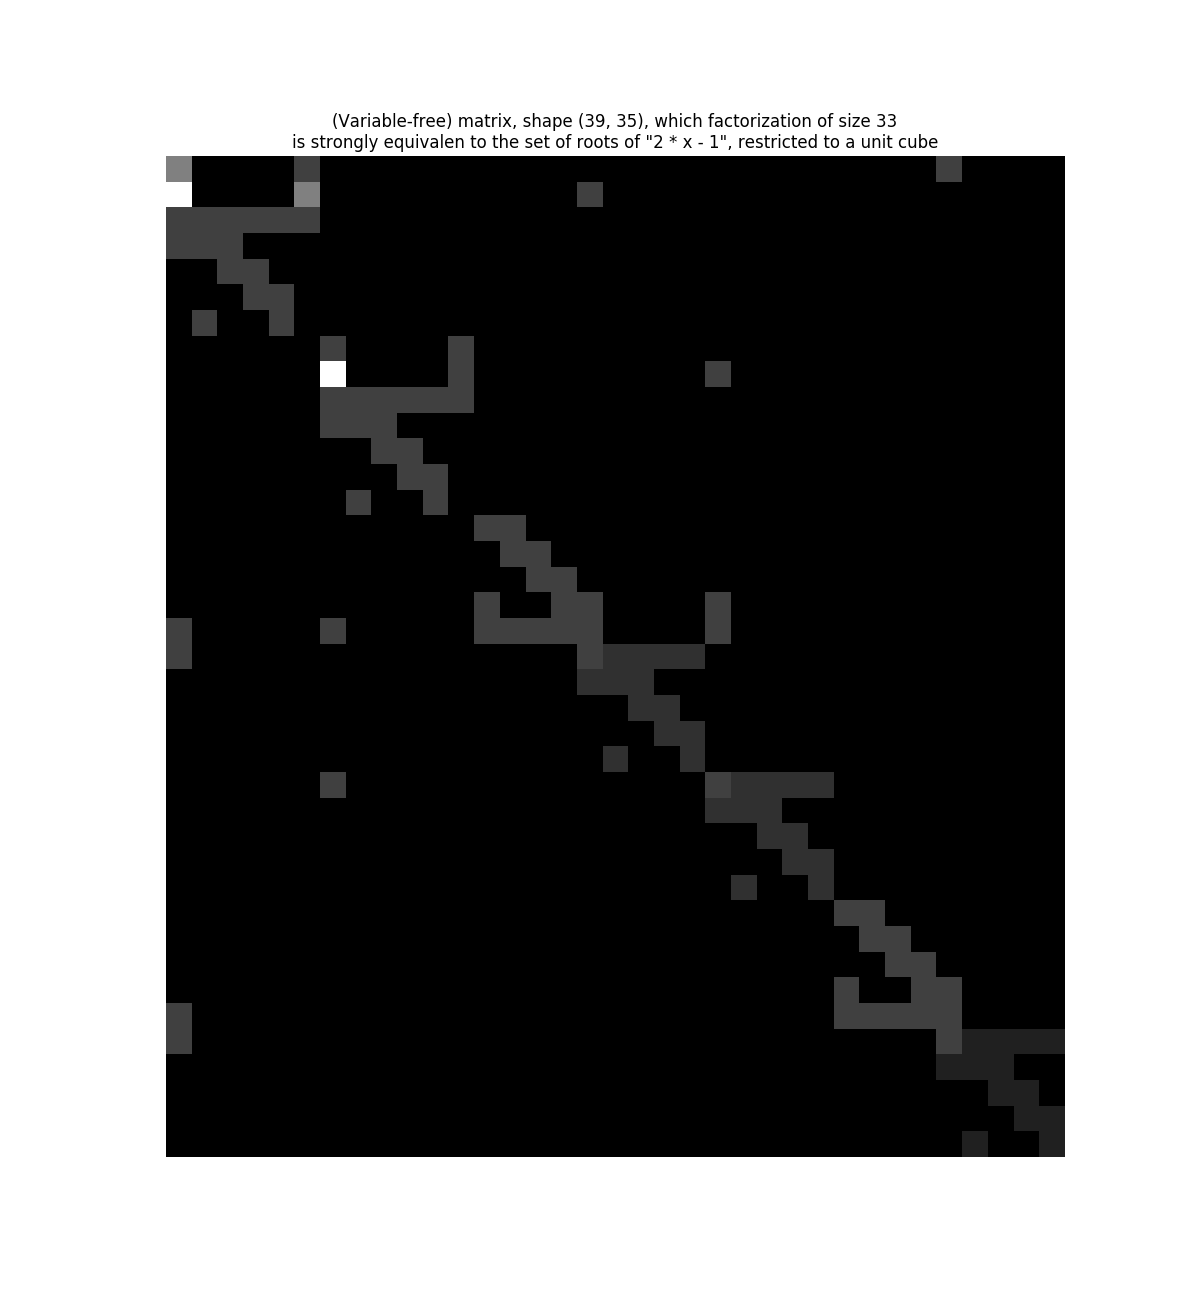

<IPython.core.display.Javascript object>


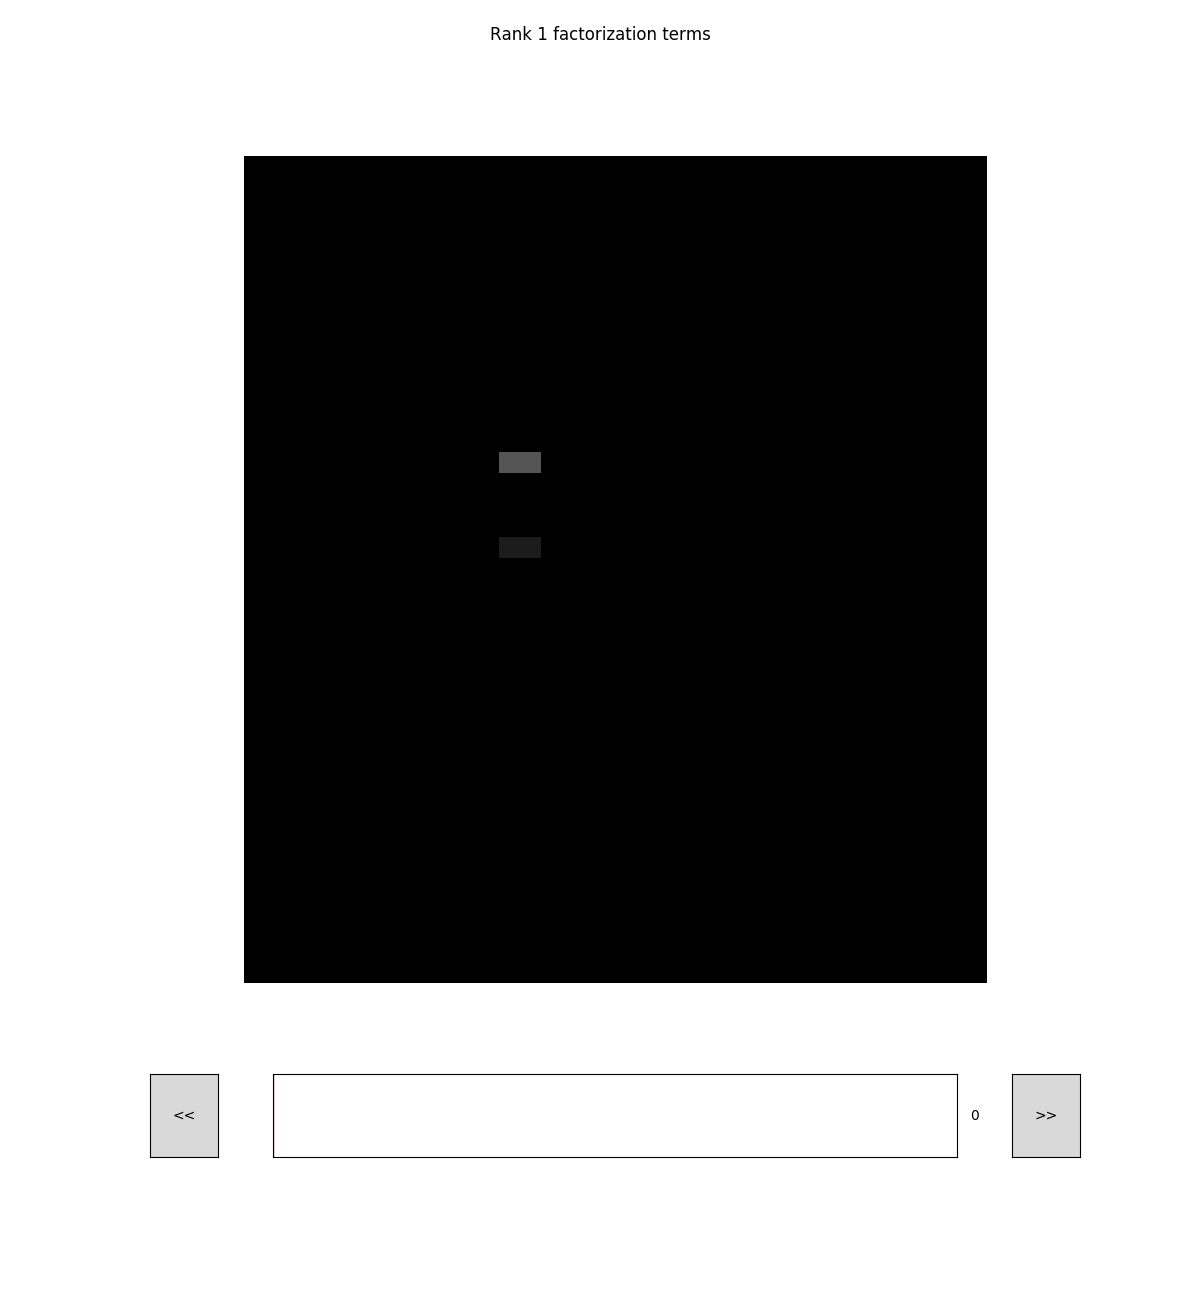

Factorization accuracy:
Frobenius norm of the difference between the sum of the factorization terms and a variable free matrix = 0.0(should be 0)

provided solution: {'x': 0.5, '_L': 1.0}
solution, obtained from factorization: {'x': 0.5, '_L': 1.0}

Following about about the matrix construction was recorder and used:
{
	"positive": {
		"p": {
			"var_result": "_L",
			"vars": [
				"x"
			],
			"coeffs": [
				2.0
			],
			"idx": [
				"slice(0, 7, None)",
				"slice(0, 6, None)"
			]
		},
		"s": {
			"expanded_vars": [],
			"idxs": []
		}
	},
	"negative": {
		"p": {
			"var_result": "_L",
			"vars": [],
			"coeffs": [
				1.0
			],
			"idx": [
				"slice(7, 14, None)",
				"slice(6, 12, None)"
			]
		},
		"s": {
			"expanded_vars": [],
			"idxs": []
		}
	},
	"ranges": {
		"_L": [
			0,
			3.0
		],
		"x": [
			0.0,
			1.0
		]
	},
	"var_counts": {
		"_L": 2,
		"x": 1
	}
}


In [12]:
formula = "2 * x - 1"
solution = dict(
    x=0.5
)

demonstrate_transformations(formula, solution)

x*y


<IPython.core.display.Javascript object>


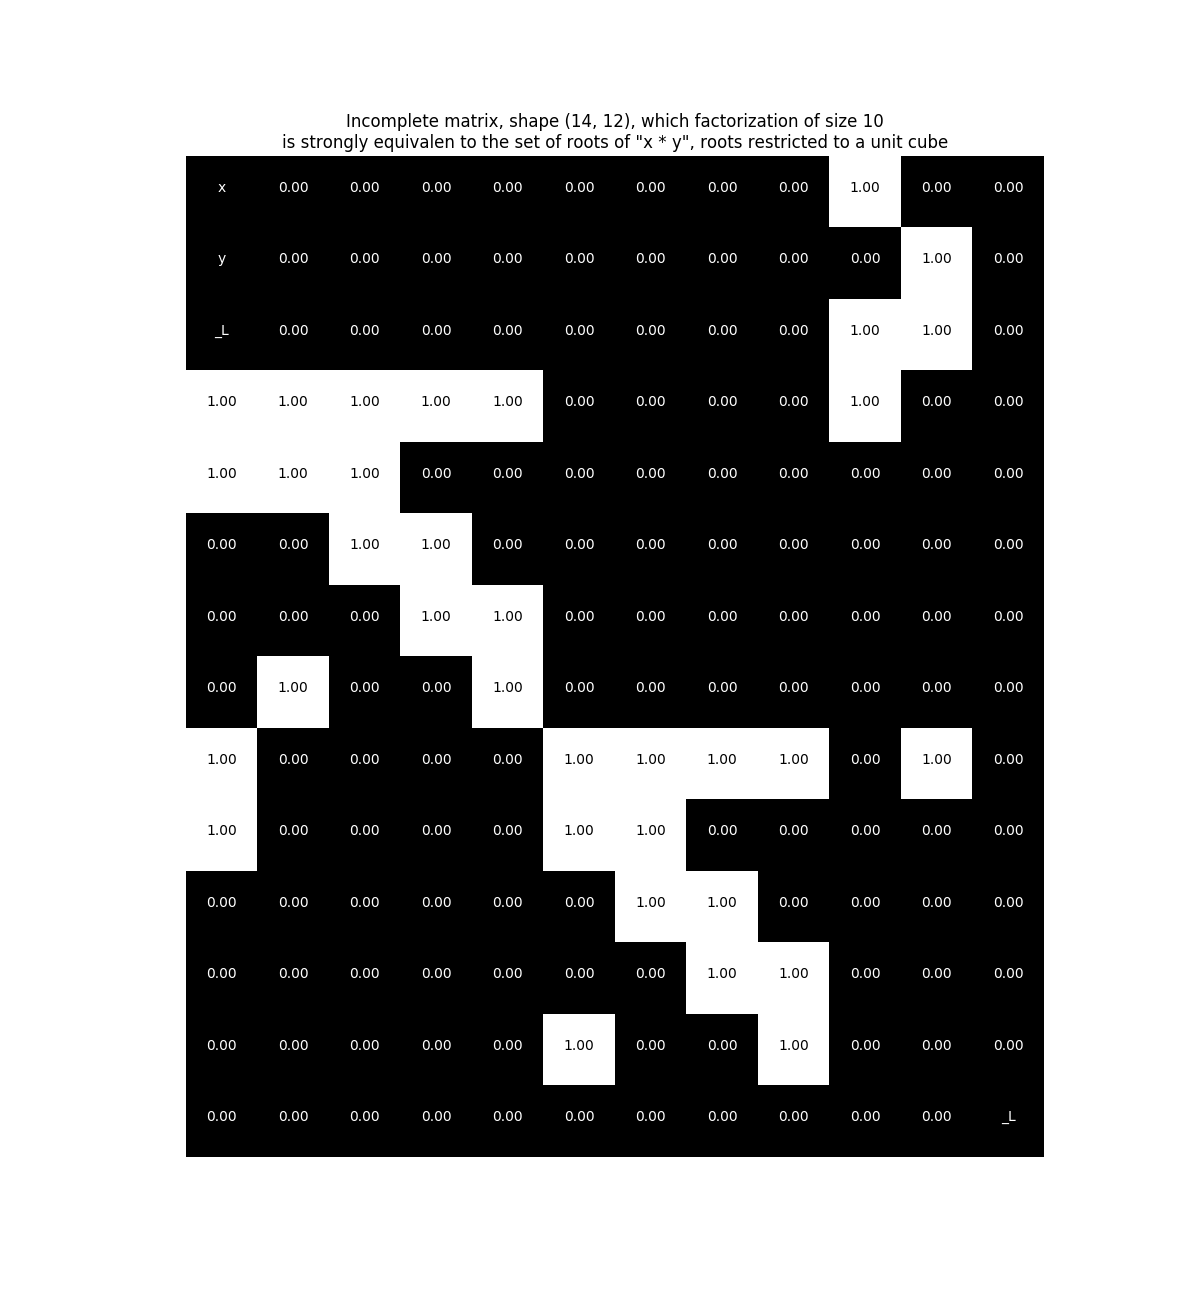

remove_variable _L
remove_variable x
remove_variable y


<IPython.core.display.Javascript object>


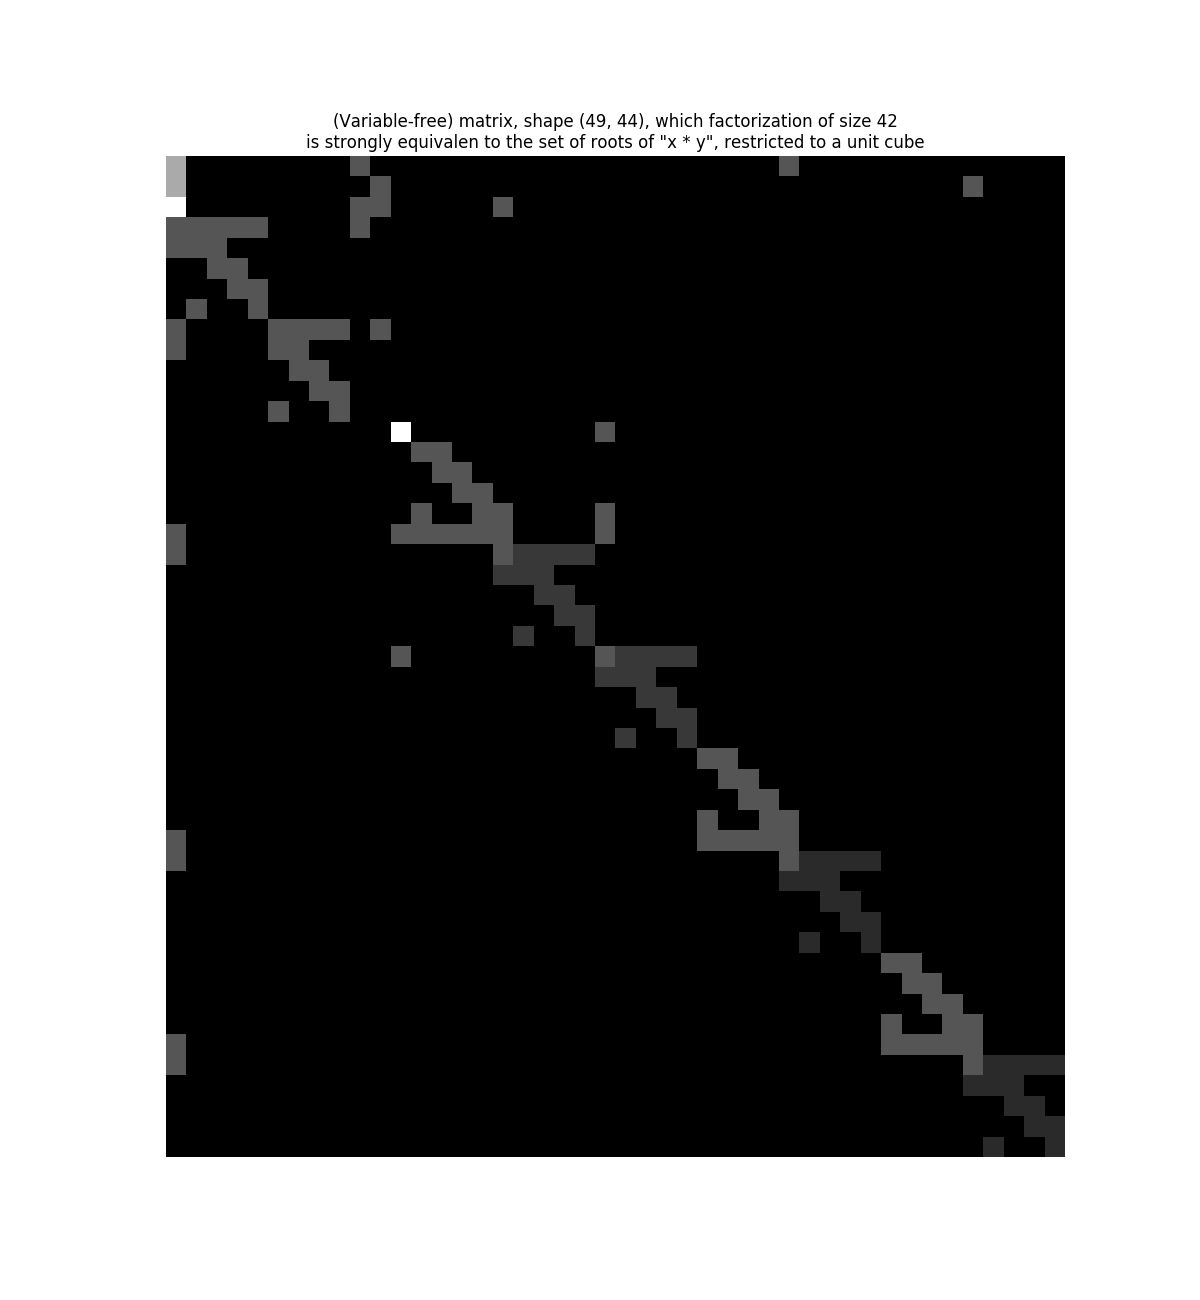

<IPython.core.display.Javascript object>


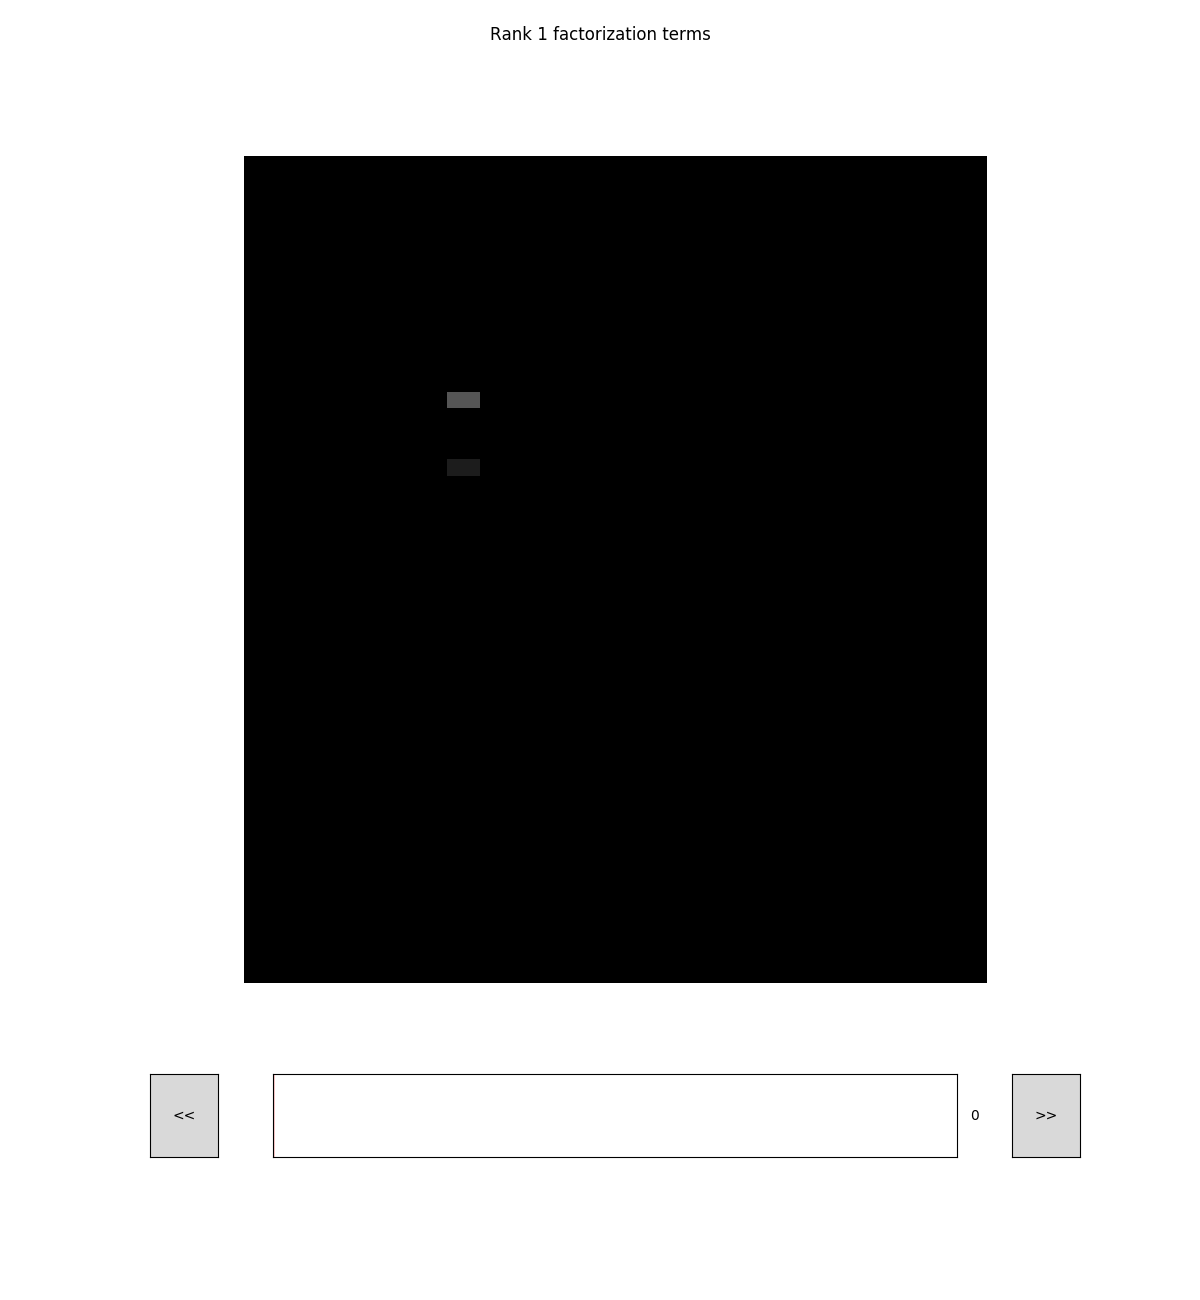

Factorization accuracy:
Frobenius norm of the difference between the sum of the factorization terms and a variable free matrix = 5.661048867003676e-16(should be 0)

provided solution: {'x': 0, 'y': 0, '_L': 0.0}
solution, obtained from factorization: {'x': 0.0, 'y': 0.0, '_L': 0.0}

Following about about the matrix construction was recorder and used:
{
	"positive": {
		"p": {
			"var_result": "_L",
			"vars": [
				"x",
				"y"
			],
			"coeffs": [
				1.0,
				1.0
			],
			"idx": [
				"slice(0, 13, None)",
				"slice(0, 11, None)"
			]
		},
		"s": {
			"expanded_vars": [],
			"idxs": []
		}
	},
	"negative": {
		"p": {
			"var_result": "_L",
			"vars": [],
			"coeffs": [],
			"idx": [
				"slice(13, 14, None)",
				"slice(11, 12, None)"
			]
		},
		"s": {
			"expanded_vars": [],
			"idxs": []
		}
	},
	"ranges": {
		"_L": [
			0,
			2.0
		],
		"x": [
			0.0,
			1.0
		],
		"y": [
			0.0,
			1.0
		]
	},
	"var_counts": {
		"_L": 2,
		"x": 1,
		"y": 1
	}
}


In [11]:

formula = "x * y"
solution = dict(
    x=0, 
    y=0
)

demonstrate_transformations(formula, solution)

x + y


<IPython.core.display.Javascript object>


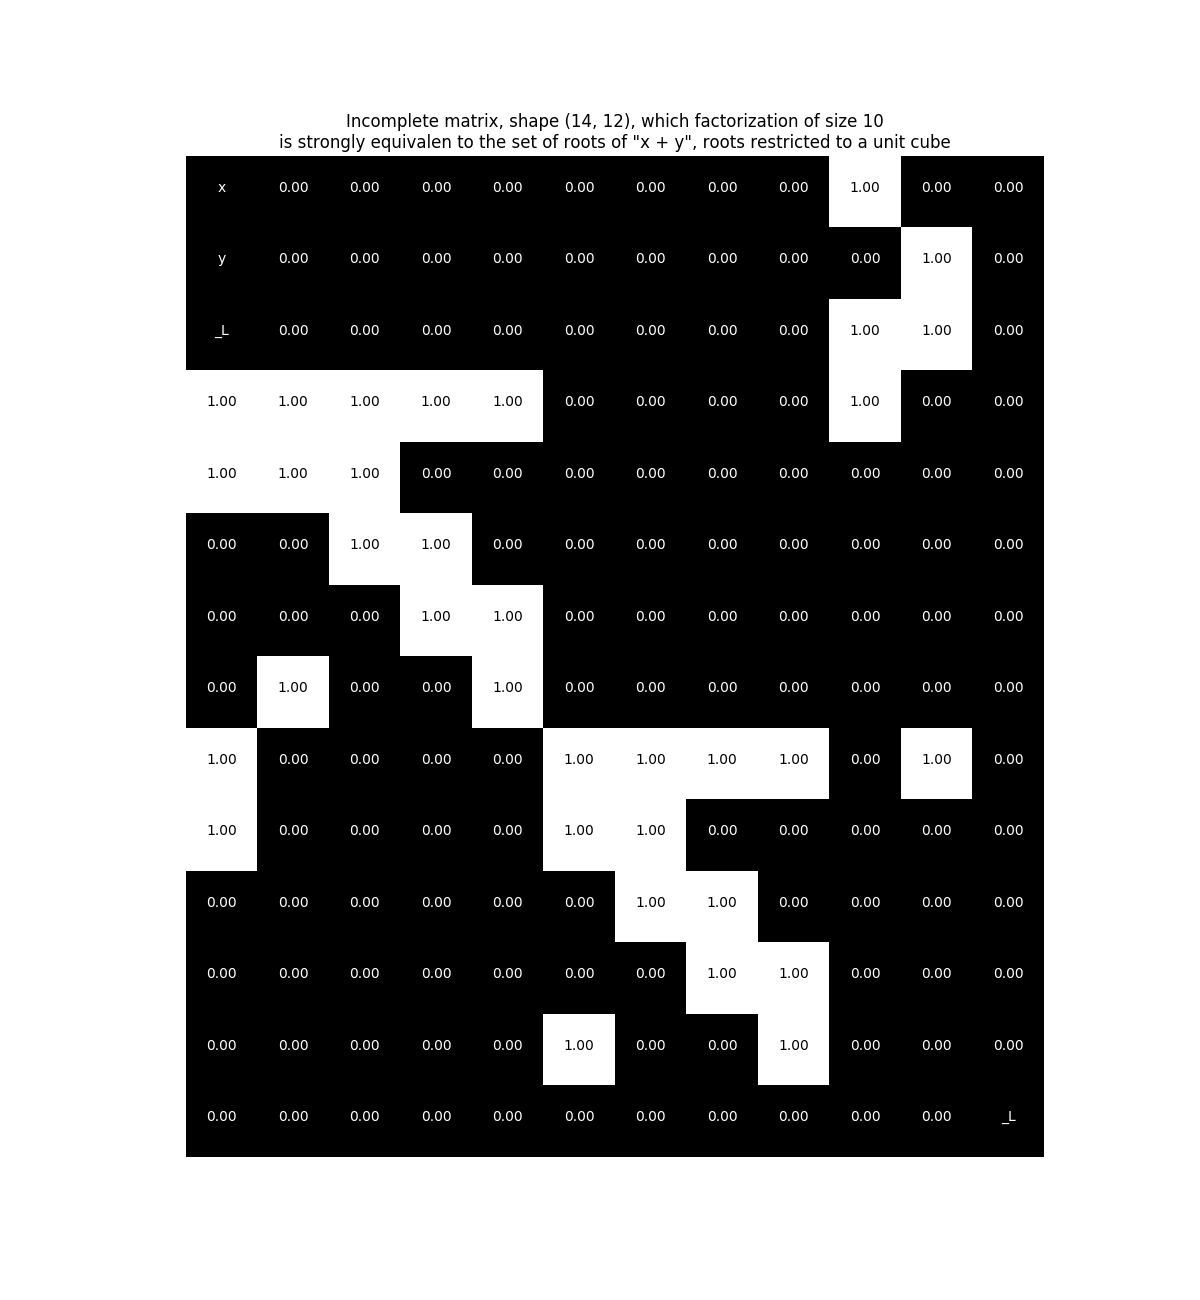

remove_variable _L
remove_variable x
remove_variable y


<IPython.core.display.Javascript object>


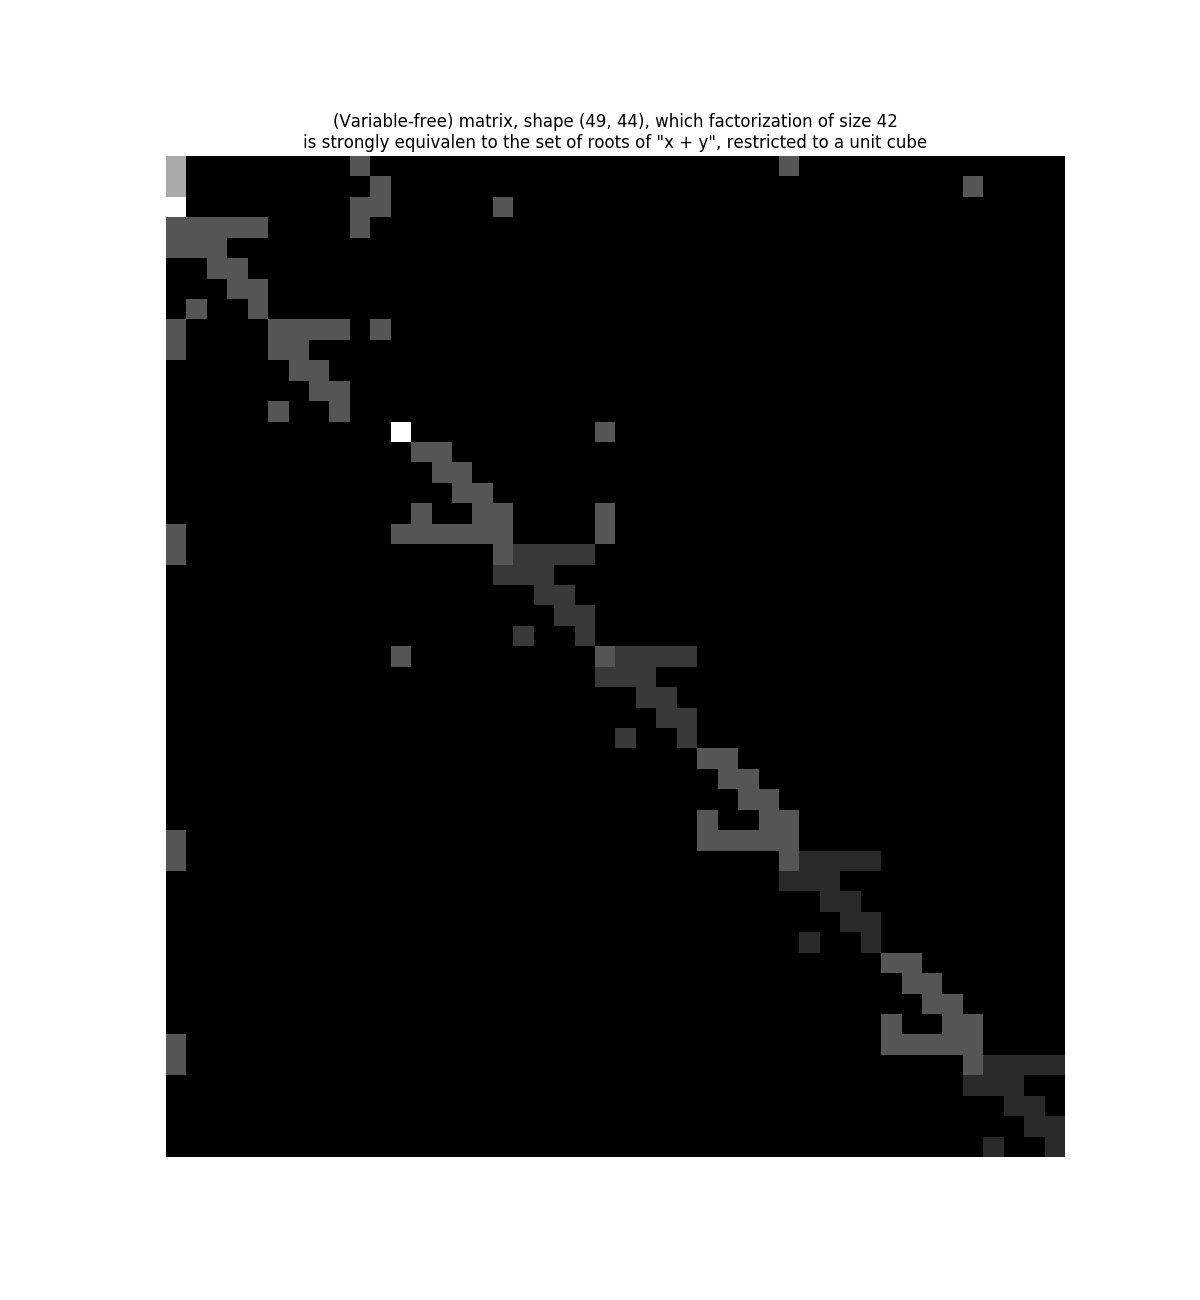

<IPython.core.display.Javascript object>


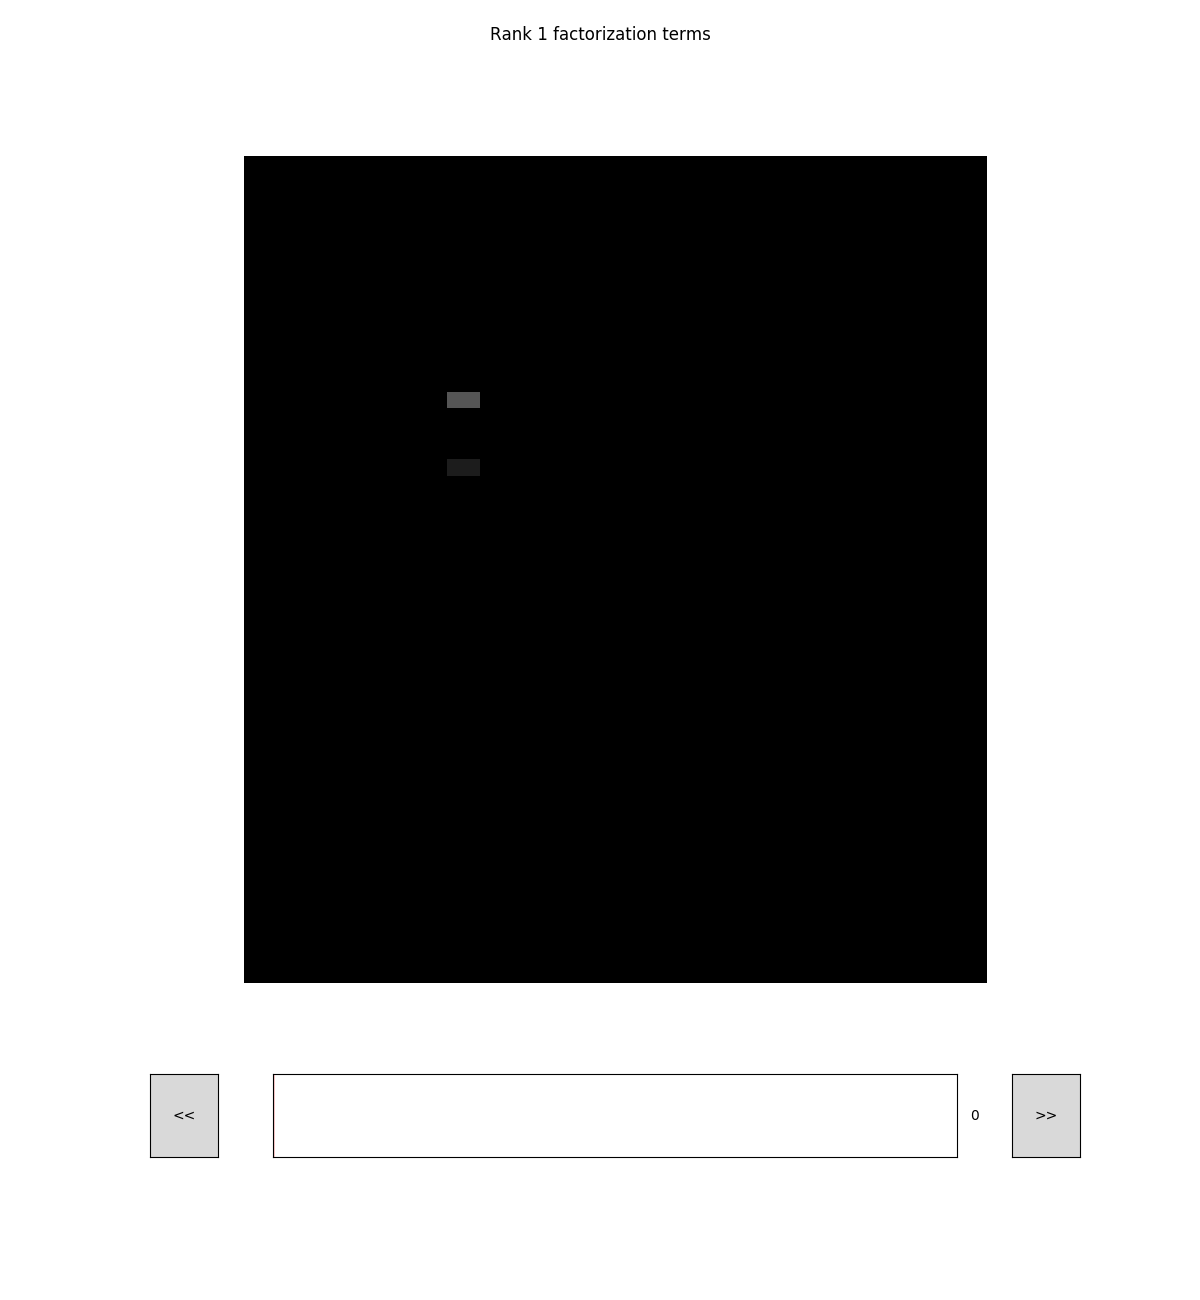

Factorization accuracy:
Frobenius norm of the difference between the sum of the factorization terms and a variable free matrix = 5.661048867003676e-16(should be 0)

provided solution: {'x': 0, 'y': 0, '_L': 0.0}
solution, obtained from factorization: {'x': 0.0, 'y': 0.0, '_L': 0.0}

Following about about the matrix construction was recorder and used:
{
	"positive": {
		"p": {
			"var_result": "_L",
			"vars": [
				"x",
				"y"
			],
			"coeffs": [
				1.0,
				1.0
			],
			"idx": [
				"slice(0, 13, None)",
				"slice(0, 11, None)"
			]
		},
		"s": {
			"expanded_vars": [],
			"idxs": []
		}
	},
	"negative": {
		"p": {
			"var_result": "_L",
			"vars": [],
			"coeffs": [],
			"idx": [
				"slice(13, 14, None)",
				"slice(11, 12, None)"
			]
		},
		"s": {
			"expanded_vars": [],
			"idxs": []
		}
	},
	"ranges": {
		"_L": [
			0,
			2.0
		],
		"x": [
			0.0,
			1.0
		],
		"y": [
			0.0,
			1.0
		]
	},
	"var_counts": {
		"_L": 2,
		"x": 1,
		"y": 1
	}
}


In [10]:
formula = "x + y"
solution = dict(
    x=0, 
    y=0
)

demonstrate_transformations(formula, solution)

x*y - 3*x + 1


<IPython.core.display.Javascript object>


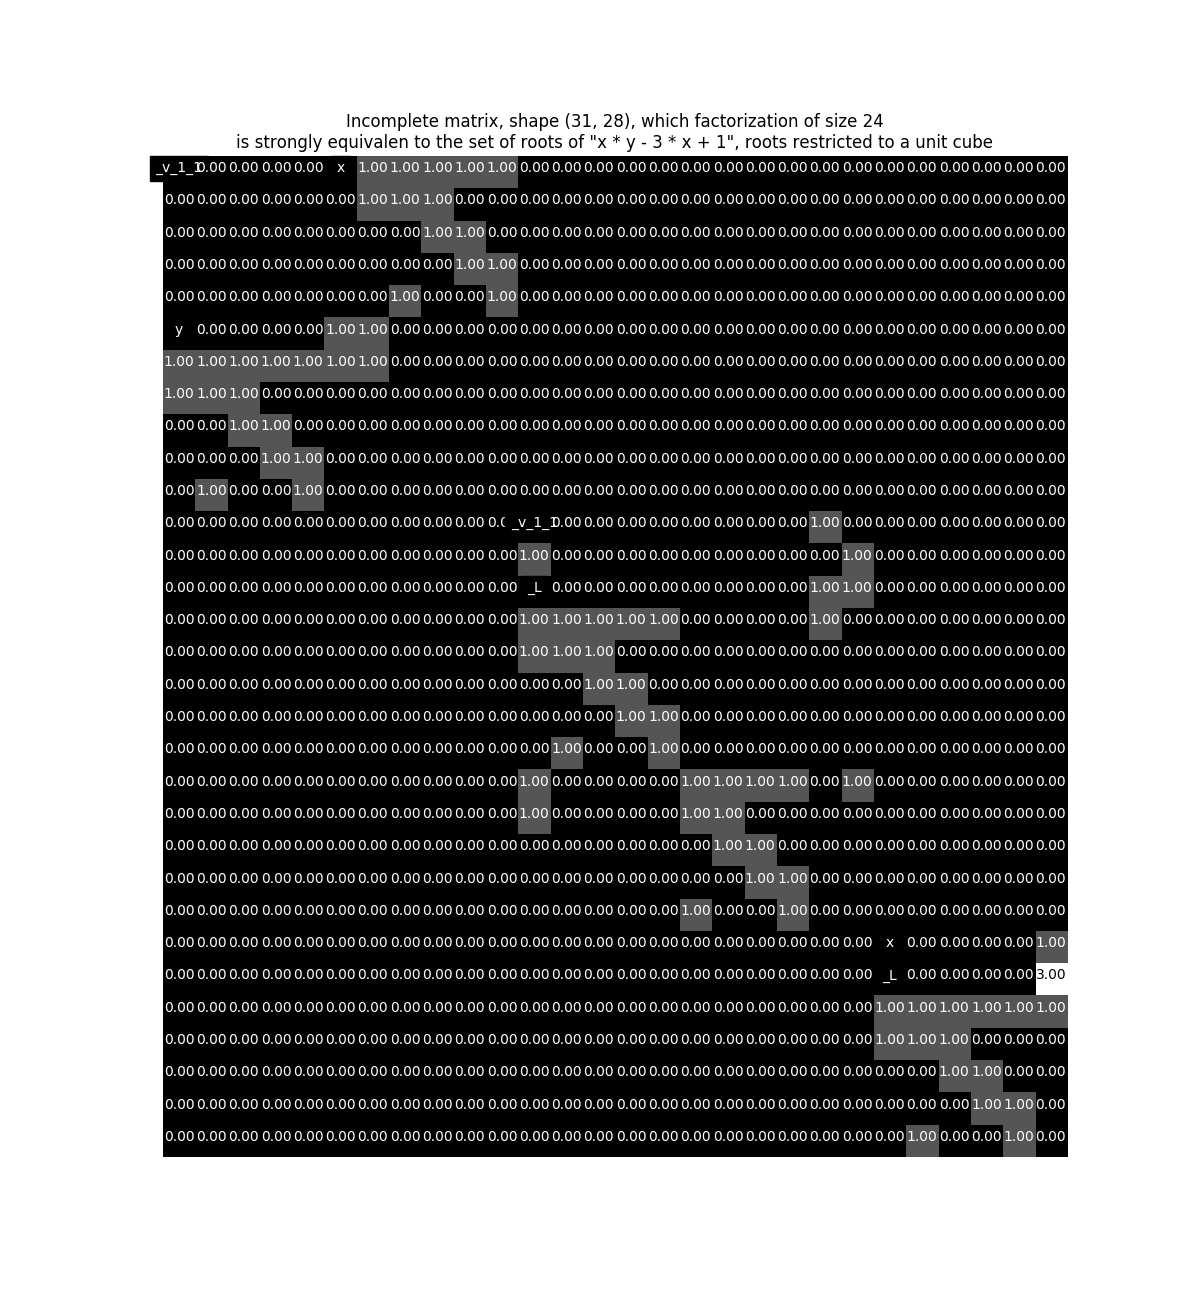

remove_variable x
remove_variable _L
remove_variable y
remove_variable _v_1_1


<IPython.core.display.Javascript object>


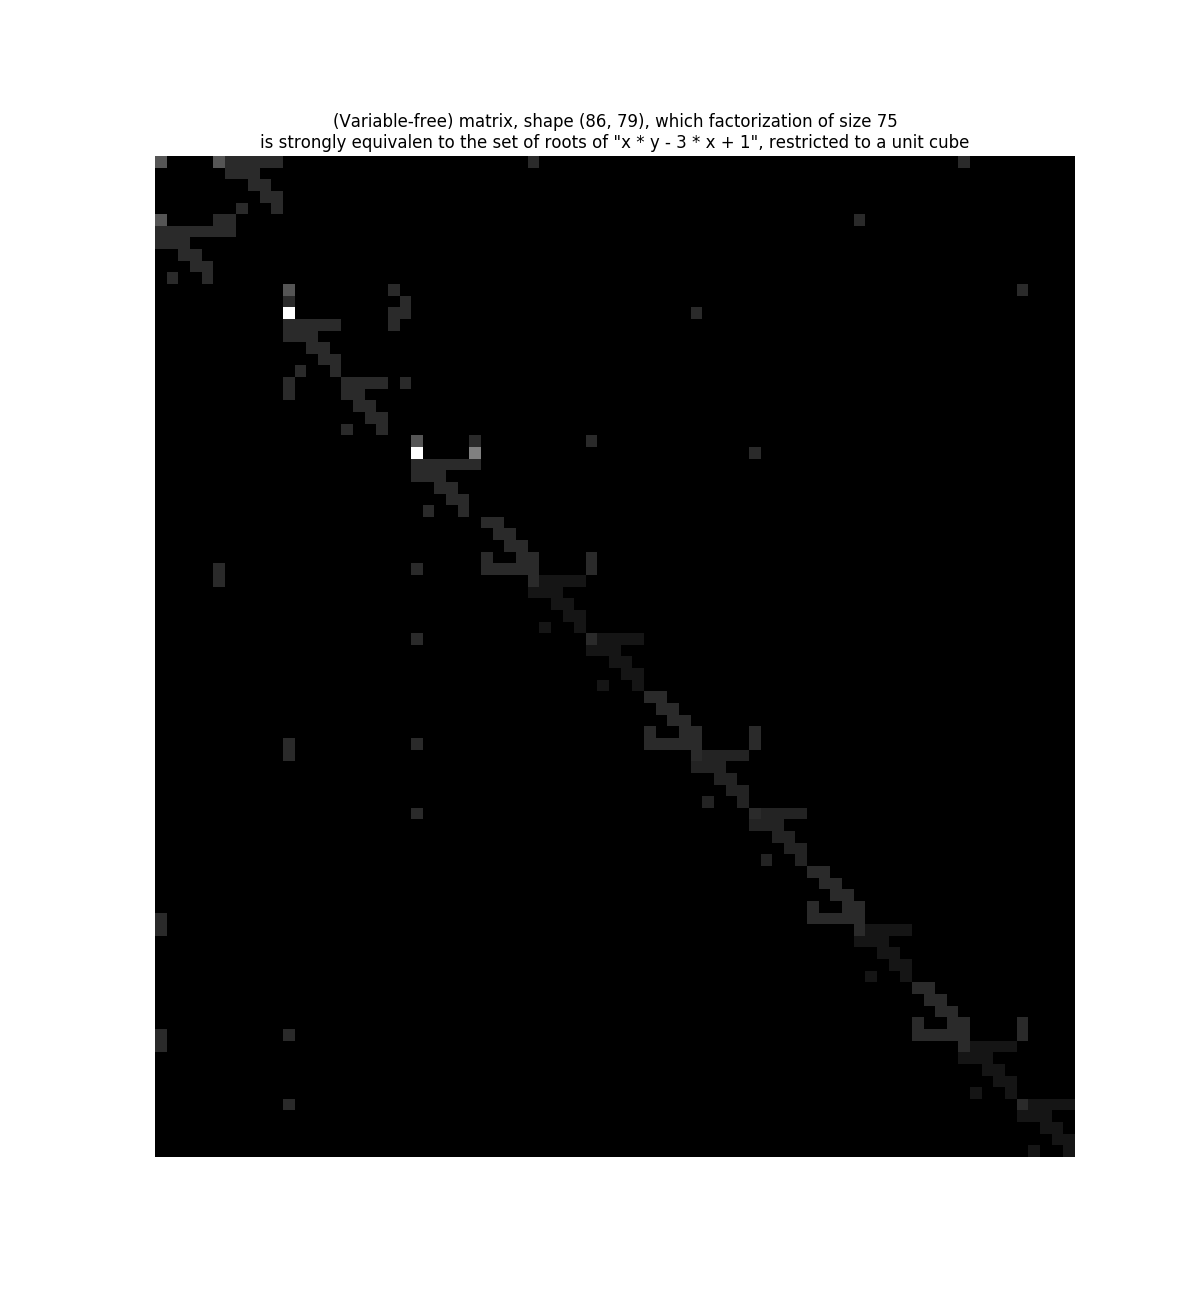

<IPython.core.display.Javascript object>


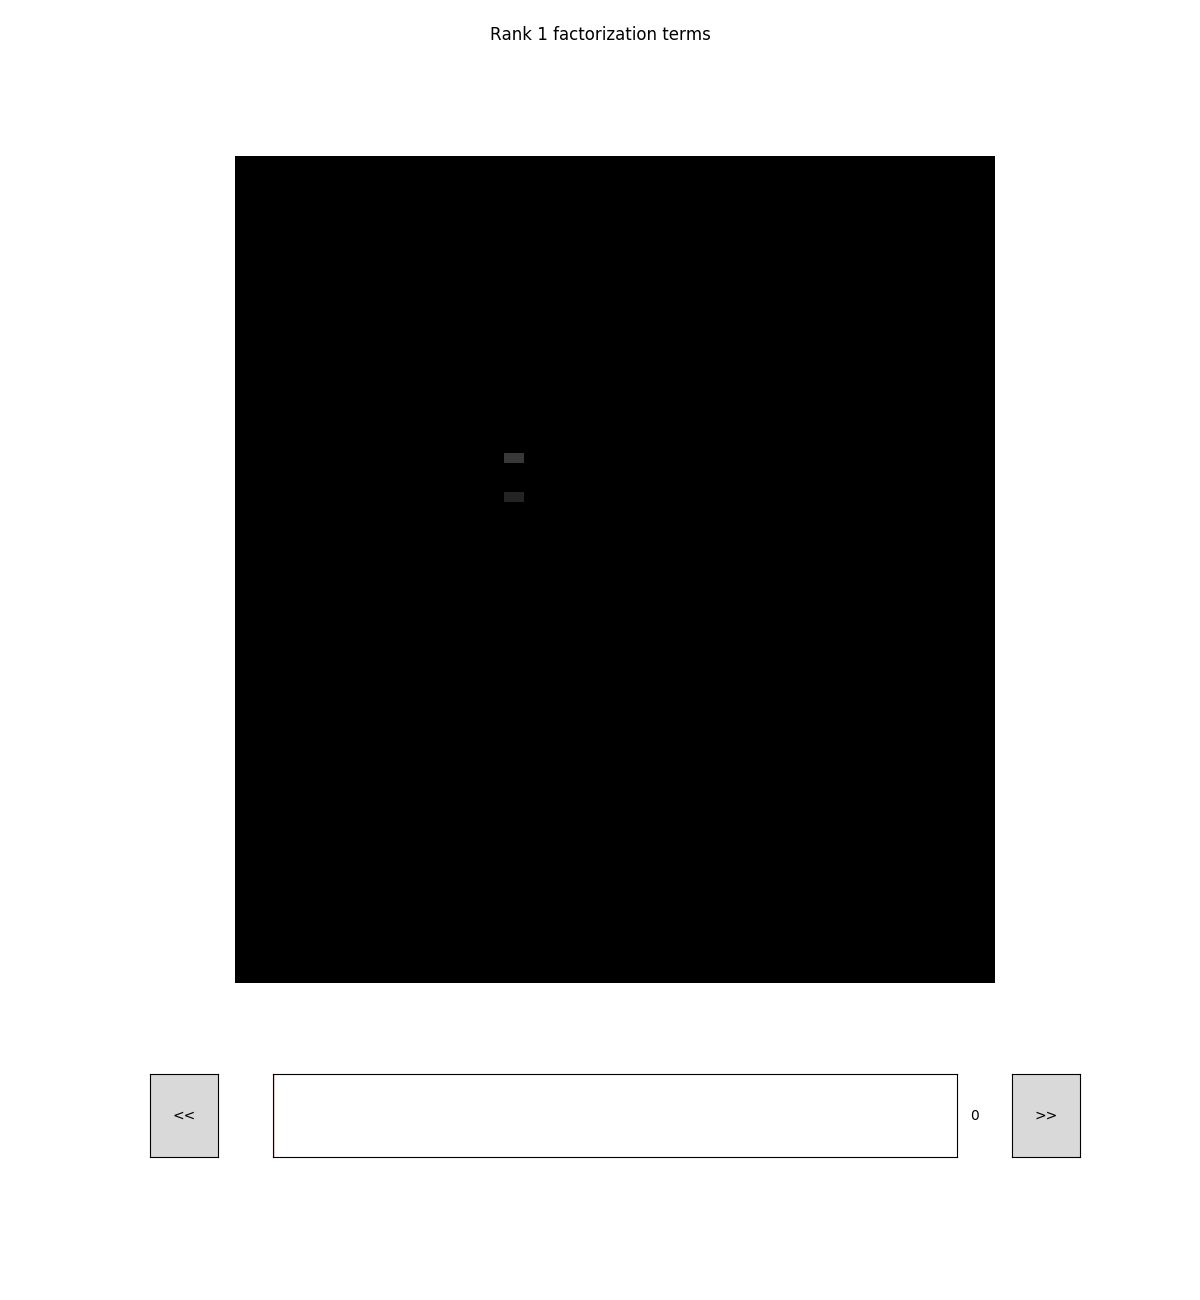

Factorization accuracy:
Frobenius norm of the difference between the sum of the factorization terms and a variable free matrix = 0.0(should be 0)

provided solution: {'x': 0.5, 'y': 1.0, '_v_1_1': 0.5, '_L': 1.5}
solution, obtained from factorization: {'_v_1_1': 0.5, 'x': 0.5, 'y': 0.0, '_L': 1.5}

Following about about the matrix construction was recorder and used:
{
	"positive": {
		"p": {
			"var_result": "_L",
			"vars": [
				"_v_1_1"
			],
			"coeffs": [
				1,
				1.0
			],
			"idx": [
				"slice(11, 24, None)",
				"slice(11, 22, None)"
			]
		},
		"s": {
			"expanded_vars": [
				[
					"_v_1_1",
					"x",
					"y"
				]
			],
			"idxs": [
				[
					"slice(0, 11, None)",
					"slice(0, 11, None)"
				]
			]
		}
	},
	"negative": {
		"p": {
			"var_result": "_L",
			"vars": [
				"x"
			],
			"coeffs": [
				3.0
			],
			"idx": [
				"slice(24, 31, None)",
				"slice(22, 28, None)"
			]
		},
		"s": {
			"expanded_vars": [],
			"idxs": []
		}
	},
	"ranges": {
		"x": [
			0.0,
		

In [9]:
formula = "x * y - 3 * x + 1"
solution = dict(
    x=0.5,
    y=1.0
)

demonstrate_transformations(formula, solution)